## Contents

### 1. Load data

### 2. Text preprocessing for deep learning models

**2.1 keep speeches whose length are between a minimum occurence and a maximum occurence**

**2.2 keep sppeches only with tokens with a minimum occurence**

**2.3 word embedding plot**

### 3. Models

**3.1 Pretrained GloVe word embedding + LSTM**

**3.2 Pretrained GloVe word embedding + CNN + LSTM**

In [39]:
import pandas as pd
import numpy as np
import pickle
import string
import re
import numpy as np
import os
from collections import Counter
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

#sklearn
from sklearn.model_selection import train_test_split

#keras
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras import models
from keras import layers
from keras import regularizers

# data preprocessing
import data_preprocessing

# nlp packages
from gensim.models import Word2Vec

# machine learning packages
from sklearn.decomposition import PCA

# plot
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### 1. load data 

In [2]:
data = data_preprocessing.read_data('./data/data.csv')
train_corpus, test_corpus, train_labels, test_labels = data_preprocessing.split(data)

### 2. Text preprocessing for deep learning models

**2.1 keep speeches whose length are between a minimum occurence and a maximum occurence**

In [3]:
# remove speeches whose length is shorter than 5 or longer than 200 for training data
def get_fixed_length_range_data(corpus,labels,min_len,max_len):
    '''
    remove speeches whose length is shorter than min_len or longer than max_len 
    input: speeches
    output: target corpus, target labels
    '''
    new_corpus = []
    new_labels = []
    for i in range(len(corpus)):
        if len(corpus[i].split()) > min_len and len(corpus[i].split()) <= max_len :
            new_corpus.append(corpus[i])
            new_labels.append(labels[i])
        else:
            continue
    return new_corpus, new_labels

In [4]:
new_train_corpus, new_train_labels = get_fixed_length_range_data(train_corpus,train_labels,5,200)
new_test_corpus, new_test_labels = get_fixed_length_range_data(test_corpus,test_labels,5,200)

In [5]:
# relabel '-1' to '0' for train_labels for later deep learning model
for i in range(len(new_train_labels)):
    if new_train_labels[i]==-1:
        new_train_labels[i]=0    

In [6]:
# relabel '-1' to '0' for test_labels for later deep learning model
for j in range(len(new_test_labels)):
    if new_test_labels[j]==-1:
        new_test_labels[j]=0   

**2.2 keep sppeches only with tokens with a minimum occurence**

In [7]:
def get_common_tokens(min_occurence,max_occurence):
    '''
    get the vocab of the whole corpus
    '''
    vocab = Counter()
    corpus = new_train_corpus + new_test_corpus
    for speech in corpus:
        tokens = speech.split()
        vocab.update(tokens)
    # keep tokens with a min occurence
    common_tokens = [k for k,c in vocab.items() if c > min_occurence and c < max_occurence]
    
    # new vocab
    new_dic = {}
    for k,c in vocab.items(): 
        if c > min_occurence and c < max_occurence:
            new_dic[k]=c
        
    return common_tokens

In [8]:
def clean_corpus(corpus,min_occurence,max_occurence):
    '''
    ensure all speeches in a corpus only keep tokens with a min occurence
    input: corpus, common tokens with a min occurence in the whole corpus
    output: new target corpus
    '''
    common_tokens = get_common_tokens(min_occurence,max_occurence)
    new_corpus = []
    for i in tqdm(range(len(corpus))):
        tokens = corpus[i].split()
        tokens = [w for w in tokens if w in common_tokens]
        new_speech = ' '.join(tokens)
        new_corpus.append(new_speech)
    return new_corpus

In [9]:
new_train_corpus2 = clean_corpus(new_train_corpus,1000,80000)

In [10]:
new_test_corpus2 = clean_corpus(new_test_corpus,1000,80000)

**2.3 word embedding plot**

In [52]:
def plot_word_embedding(sentences,filename):
    '''
    plot 2D word embedding for a corpus
    '''
    model = Word2Vec(sentences,min_count=5000)
    # fit a 2d PCA model to the vectors
    X = model[model.wv.vocab]
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    # create a scatter plot of the projection
    plt.figure(figsize=(16,10))
    plt.scatter(result[:,0],result[:,1])
    words = list(model.wv.vocab)
    for i, word in enumerate(words):
        plt.annotate(word,xy=(result[i,0],result[i,1]))
    plt.show()
    #plt.savefig(filename)

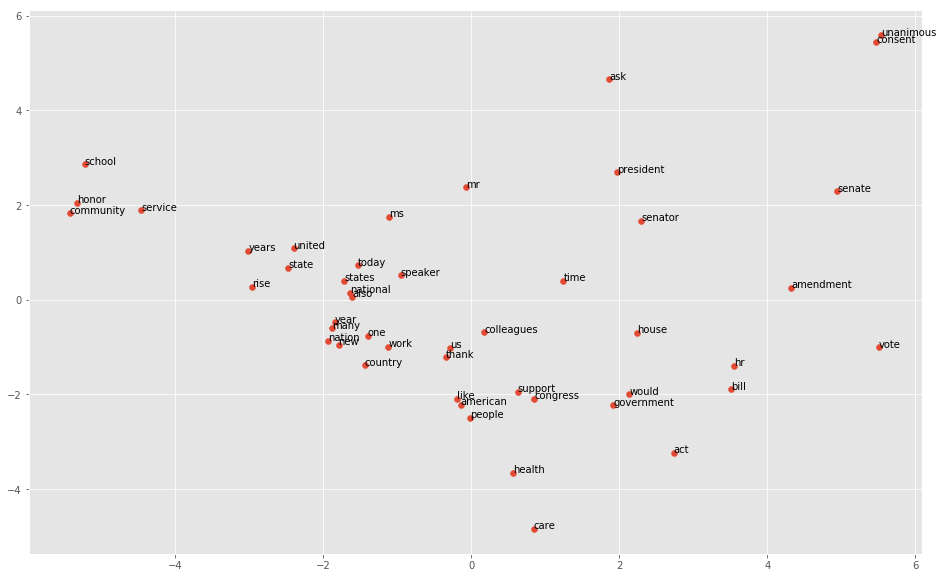

In [53]:
corpus = new_train_corpus2 + new_test_corpus2
sentences = [i.split() for i in corpus]
plot_word_embedding(sentences,'./graphs/wv.png')

### 3. Models

**3.1 pretrained GloVe word embedding + LSTM**

In [11]:
#tokenization
corpus = new_train_corpus2 + new_test_corpus2
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
#tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i > num_words}

In [12]:
train_sequences = tokenizer.texts_to_sequences(new_train_corpus2)
test_sequences = tokenizer.texts_to_sequences(new_test_corpus2)
train_padded = pad_sequences(train_sequences, maxlen=200)
test_padded = pad_sequences(test_sequences, maxlen=200)

In [13]:
# vocab_size
vocab_size = len(tokenizer.word_index) + 1

In [16]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('./GloVe/glove.6B.100d.txt') 
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [17]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [36]:
glove_model = models.Sequential()
glove_model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=200, trainable=False))
glove_model.add(Dropout(0.2))
glove_model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.2))
glove_model.add(layers.Dense(1, activation='sigmoid'))
#With the set_weights method we load the pre-trained embeddings in the Embedding layer (here layer 0). 
#By setting the trainable attribute to False, we make sure not to change the pre-trained embeddings.
glove_model.layers[0].set_weights([embedding_matrix])
glove_model.layers[0].trainable = False
glove_model.summary()
#plot_model(glove_model,to_file='glove_lstm.png',show_shapes=True)
glove_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 100)          41000     
_________________________________________________________________
dropout_5 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 121,501
Trainable params: 80,501
Non-trainable params: 41,000
_________________________________________________________________


In [20]:
history = glove_model.fit(train_padded, 
                          np.array(new_train_labels), 
                          epochs=10,
                          verbose=False,
                          validation_split=0.3)

training...


In [21]:
loss, accuracy = glove_model.evaluate(train_padded, np.array(new_train_labels), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = glove_model.evaluate(test_padded, np.array(new_test_labels), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9324
Testing Accuracy:  0.9334


In [22]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

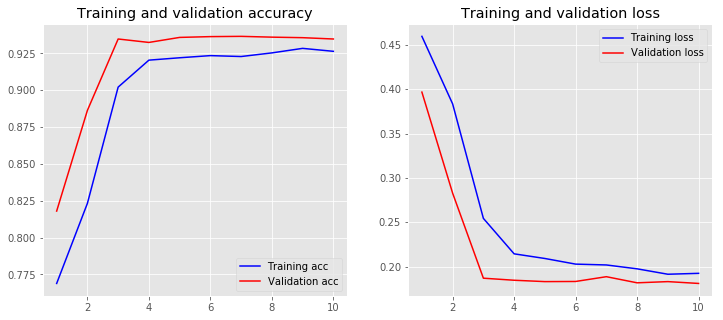

In [23]:
plot_history(history)

**3.2 pretrained GloVe word embedding + CNN + LSTM**

In [30]:
# define the model
def define_cnn_lstm_model(vocab_size):
    model_conv = Sequential()
    model_conv.add(Embedding(vocab_size, 100, input_length=200))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(32, 3, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=2))
    model_conv.add(LSTM(100))
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.layers[0].set_weights([embedding_matrix])
    model_conv.layers[0].trainable = False
    model_conv.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    model_conv.summary()
    #plot_model(model_conv, to_file='cnn_lstm.png', show_shapes=True)
    return model_conv

In [31]:
# define model
glove_model_CNN_LSTM = define_cnn_lstm_model(vocab_size)
# fit model
history_cnn_lstm = glove_model_CNN_LSTM.fit(train_padded, 
                                            np.array(new_train_labels), 
                                            epochs=10,
                                            verbose=False,
                                            validation_split=0.3)
# save the model
#glove_model_CNN_LSTM.save('glove_model_CNN_LSTM.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 100)          41000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 198, 32)           9632      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 99, 32)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 103,933
Trainable params: 62,933
Non-trainable params: 41,000
_________________________________________________________________


In [32]:
loss, accuracy = glove_model_CNN_LSTM.evaluate(train_padded, np.array(new_train_labels), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = glove_model_CNN_LSTM.evaluate(test_padded, np.array(new_test_labels), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9394
Testing Accuracy:  0.9340


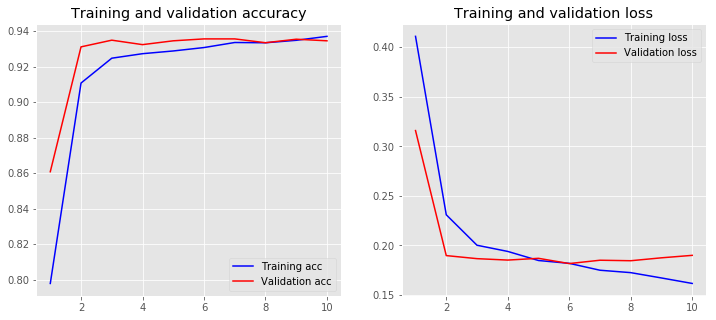

In [33]:
plot_history(history_cnn_lstm)